In [181]:
gpt_specs = {
        "num_layers": 2,
        "num_heads": 8,
        "head_size": 32,
        "vocab_size": 50259,
        "hidden_size": 256,
        "max_position_embeddings": 512
}

import json
import days.w3d2.w3d2_tests as w3d2_tests
import transformers
import torch
from einops import rearrange, reduce, repeat

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
VOCAB_SIZE = 50259
MAX_SEQ_LEN = 512

In [ ]:
model = w3d2_tests.get_minigpt("../w3d2/model.pt")
tokenizer = transformers.GPT2Tokenizer.from_pretrained("gpt2")
tokenizer._add_tokens(["[BEGIN]", "[END]"])
tokenizer.pad_token = "[END]"
tokenizer.eos_token = "[END]"
# 50258 is the pad_token_id
# 50257 is the BEGIN token id

with open("../w3d2/test_tokens_owt_subset.json") as f:
    test_tokens = torch.LongTensor(json.load(f))[:,:512]

sentences = ["So far, we've developed a theoretical model for understanding two-layer attention-only models.",
            "We have an overall equation describing the logits (the OV circuit), and then an equation describing how each attention head's attention pattern is computed (the QK circuit).",
             "But how do we understand them in practice?",
             "In this section, we'll reverse engineer a single two-layer model."]

In [ ]:
similarity_fn = torch.nn.CosineSimilarity(dim=-1)
token_embeddings = model.token_embedding(torch.randint(50259, (2,)))
similarity_fn(token_embeddings[0], token_embeddings[1])

tensor(0.2956, grad_fn=<DivBackward0>)

In [ ]:
tokens = tokenizer("Mexico")
tokenizer.batch_decode([ token for token in tokens.input_ids])

['Mexico']

In [ ]:
cosine_sim = torch.nn.CosineSimilarity(dim=-1)
def token_by_token_decode(tokens):
    return tokenizer.batch_decode([ token for token in tokens])

def get_word_similarity(similarity_fn, word1, word2):
    token1 = tokenizer(word1).input_ids
    token2 = tokenizer(word2).input_ids
    assert len(token1) == 1, token_by_token_decode(token1)
    assert len(token2) == 1, token_by_token_decode(token2)
    embedding1 = model.token_embedding(torch.LongTensor(token1))
    embedding2 = model.token_embedding(torch.LongTensor(token2))
    return similarity_fn(embedding1, embedding2)

get_word_similarity(similarity_fn=cosine_sim, word1="man", word2="woman")

tensor([0.4510], grad_fn=<DivBackward0>)

In [ ]:
with torch.no_grad():
    all_token_embeddings = model.token_embedding(torch.arange(VOCAB_SIZE))
all_token_embeddings.shape

In [182]:
with torch.no_grad():
    all_position_embeddings = model.pos_embedding(torch.arange(512))
all_position_embeddings.shape

torch.Size([512, 256])

In [198]:
pca = PCA(n_components=2)
# X = torch.concat([all_token_embeddings, all_position_embeddings], dim=0)
X = torch.concat([all_token_embeddings], dim=0)
print(all_token_embeddings.shape)
projected = pca.fit_transform(X)
print(projected)
projected_transpose = rearrange(projected, "x y -> y x")
print(projected_transpose)

torch.Size([50259, 256])
[[-1.2510967   0.01290521]
 [-1.48608739 -0.01644405]
 [-0.73312237  0.3562021 ]
 ...
 [ 2.32441219 -0.30274016]
 [-1.3383326   0.00557275]
 [ 2.30036494 -0.31769227]]
[[-1.2510967  -1.48608739 -0.73312237 ...  2.32441219 -1.3383326
   2.30036494]
 [ 0.01290521 -0.01644405  0.3562021  ... -0.30274016  0.00557275
  -0.31769227]]


In [203]:
word_list = tokenizer.batch_decode(range(VOCAB_SIZE))

In [207]:
word_dict = {'name': word_list, 'component 1': projected_transpose[0], 'component 2': projected_transpose[1]}

In [209]:
df = pd.DataFrame(data=word_dict)
df

name  component 1  component 2
0                  !    -1.251097     0.012905
1                  "    -1.486087    -0.016444
2                  #    -0.733122     0.356202
3                  $    -0.693218     0.326229
4                  %    -1.040699    -0.024054
...              ...          ...          ...
50254     informants     0.460060    -0.473230
50255          gazed     0.565792    -0.479671
50256  <|endoftext|>     2.324412    -0.302740
50257        [BEGIN]    -1.338333     0.005573
50258          [END]     2.300365    -0.317692

[50259 rows x 3 columns]

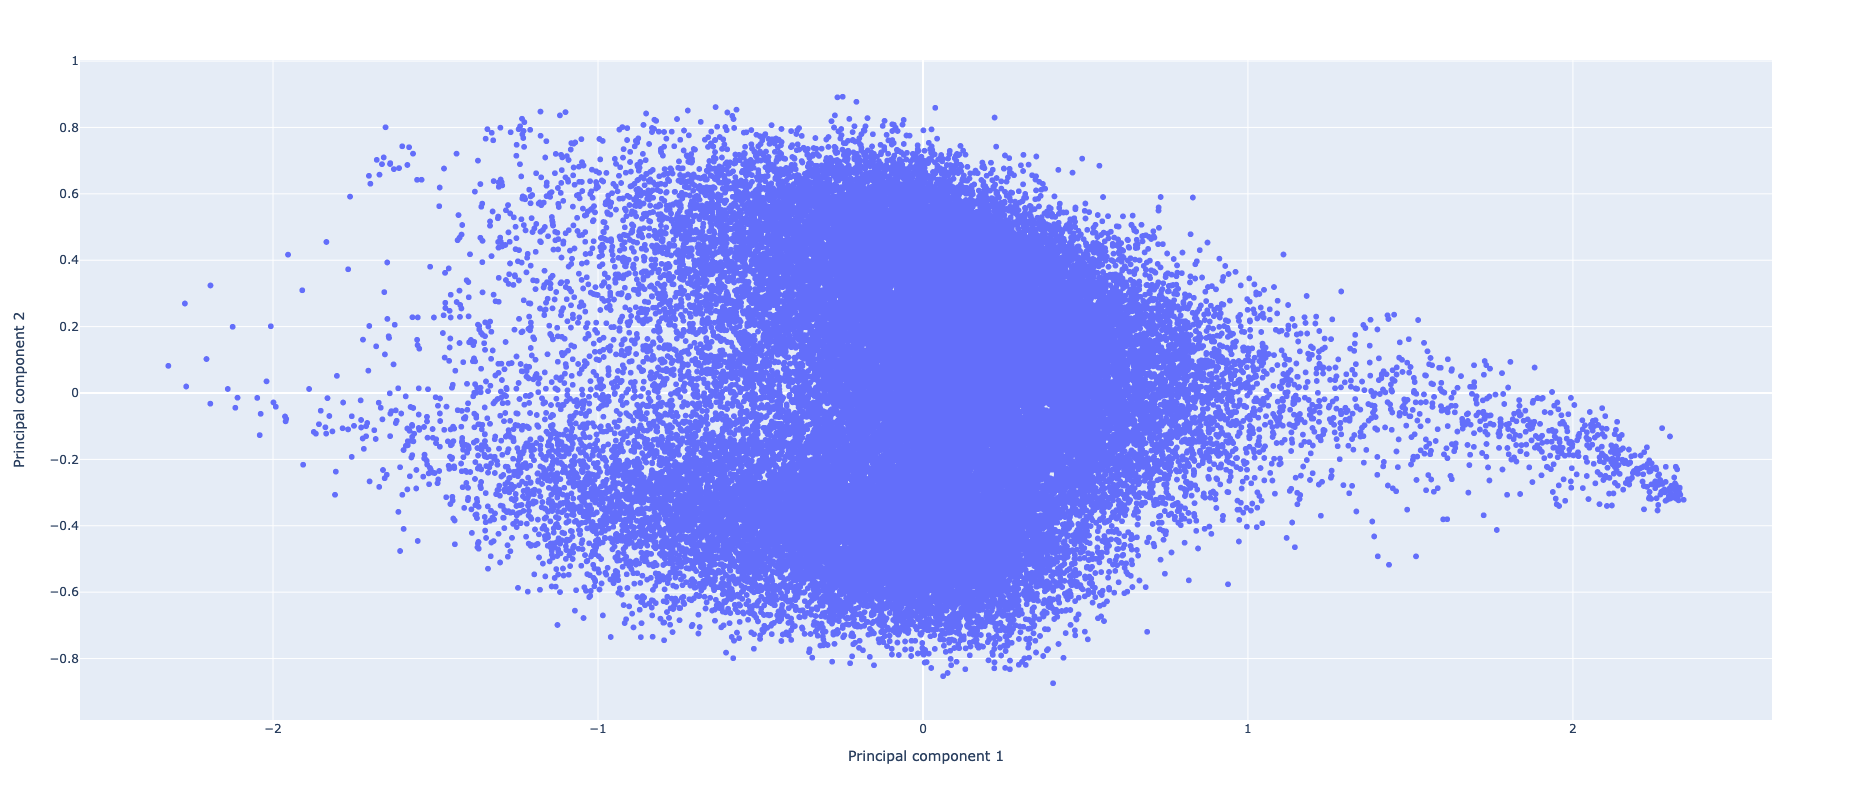

In [213]:
fig = px.scatter(
    df, 
    x="component 1", 
    y="component 2", 
    hover_name="name",
    labels={
        "component 1": "Principal component 1",
        "component 2": "Principal component 2",
    },
    width=800, 
    height=800, 
)
fig.show()